In [18]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt

C:\Users\DEVANSHI\AppData\Local\Temp/ipykernel_26832/490080173.py:55: RuntimeWarning: invalid value encountered in divide
  self.grid /= np.max(self.grid)


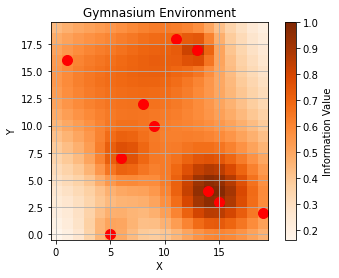

In [22]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt

class GymnasiumEnv(gym.Env):
    def __init__(self, grid_size=20, obs_size=5, num_agents=6, num_targets=20):
        super(GymnasiumEnv, self).__init__()

        self.grid_size = grid_size
        self.obs_size = obs_size
        self.num_agents = num_agents
        self.num_targets = num_targets
        self.grid = np.zeros((grid_size, grid_size))
        self.agent_pos = self.reset_agent_positions()  # Random initial agent positions
        self.targets = self.generate_targets()

        self.action_space = spaces.Discrete(5)  # Five discrete actions: up, down, left, right, stay
        self.observation_space = spaces.Box(low=0, high=1, shape=(obs_size, obs_size), dtype=np.float32)

        self.normalize_info()

    def reset_agent_positions(self):
        agent_pos = []
        for _ in range(self.num_agents):
            x = np.random.randint(self.obs_size // 2, self.grid_size - self.obs_size // 2)
            y = np.random.randint(self.obs_size // 2, self.grid_size - self.obs_size // 2)
            agent_pos.append((x, y))
        return agent_pos

    def generate_targets(self):
        targets = []
        target_positions = np.random.choice(np.arange(self.grid_size), size=self.num_targets, replace=False, p=self.position_probabilities())
        target_positions = [(x, y) for x, y in zip(target_positions[::2], target_positions[1::2])]
        for target_pos in target_positions:
            targets.append(target_pos)
        return targets

    def generate_gaussians(self):
        for target_pos in self.targets:
            mean_x, mean_y = target_pos
            sigma = np.random.uniform(1, min(self.grid_size // 2, 10))  # Ensure sigma is not too large
            x, y = np.meshgrid(np.arange(self.grid_size), np.arange(self.grid_size))
            gaussian = np.exp(-((x - mean_x)**2 + (y - mean_y)**2) / (2 * sigma**2))
            self.grid += gaussian

    def position_probabilities(self):
        probabilities = np.zeros(self.grid_size)
        for i in range(self.grid_size):
            distance_from_center = np.abs(i - (self.grid_size - 1) / 2)
            probabilities[i] = np.exp(-distance_from_center / (self.grid_size / 4))
        return probabilities / np.sum(probabilities)

    def normalize_info(self):
        self.grid /= np.max(self.grid)

    def step(self, actions):
        observations = []
        rewards = []
        dones = []
        infos = []

        for agent_id, action in enumerate(actions):
            current_pos = self.agent_pos[agent_id]

            # Update agent position based on the action
            if action == 0:  # Up
                new_pos = (current_pos[0], current_pos[1] - 1)
            elif action == 1:  # Down
                new_pos = (current_pos[0], current_pos[1] + 1)
            elif action == 2:  # Left
                new_pos = (current_pos[0] - 1, current_pos[1])
            elif action == 3:  # Right
                new_pos = (current_pos[0] + 1, current_pos[1])
            else:  # Stay in the same position
                new_pos = current_pos

            # Ensure the new position is within the grid
            new_pos = (max(self.obs_size // 2, min(new_pos[0], self.grid_size - self.obs_size // 2 - 1)),
                       max(self.obs_size // 2, min(new_pos[1], self.grid_size - self.obs_size // 2 - 1)))

            # Calculate the reward based on reaching targets
            reward = 0
            if new_pos in self.targets:
                reward = 1
                self.targets.remove(new_pos)  # Remove the reached target

            # Update agent position
            self.agent_pos[agent_id] = new_pos

            # Extract the observation (5x5 grid around the agent)
            x, y = new_pos
            observation = self.grid[x - self.obs_size // 2:x + self.obs_size // 2 + 1,
                                    y - self.obs_size // 2:y + self.obs_size // 2 + 1]

            # Append the observation, reward, done flag, and an empty info dictionary
            observations.append(observation)
            rewards.append(reward)
            dones.append(False)
            infos.append({})

        return observations, rewards, dones, infos

    def reset(self):
        # Reset the environment
        self.grid = np.zeros((self.grid_size, self.grid_size))
        self.agent_pos = self.reset_agent_positions()  # Random initial agent positions
        self.targets = self.generate_targets()
        self.generate_gaussians()  # Generate Gaussian distributions around targets
        self.normalize_info()

        observations = []
        for agent_id in range(self.num_agents):
            x, y = self.agent_pos[agent_id]
            observation = self.grid[x - self.obs_size // 2:x + self.obs_size // 2 + 1,
                                    y - self.obs_size // 2:y + self.obs_size // 2 + 1]
            observations.append(observation)

        return observations

    def render(self, mode='human'):
        plt.imshow(self.grid, cmap='Oranges', origin='lower')
        plt.colorbar(label='Information Value')
        plt.title('Gymnasium Environment')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.grid(visible=True, which="major")

        # Plot targets
        for target in self.targets:
            plt.scatter(target[0], target[1], c='r', marker='o', s=100)

        plt.show()

    def close(self):
        pass

env = GymnasiumEnv(grid_size=20, obs_size=5, num_agents=6, num_targets=20)
observations = env.reset()
env.render()